In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *

using gpu 2


In [3]:
#Checking wich GPU is beeing used

!nvidia-smi

Thu Oct 28 15:07:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   27C    P8    18W / 250W |   2217MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [4]:
# set data directory
data_dir = 'dialogue/Bjärn/images/splitfolders/'

#preparing the transform method to transform data into a Tensor object
transform = transforms.Compose([
    #transforms.RandomRotation(20),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor()]) 
    
train_set = datasets.ImageFolder(data_dir + 'train', transform=transform) #contents from the 'train' folder is put in train_set
test_set = datasets.ImageFolder(data_dir + 'test', transform=transform)
print(len(train_set))
print(len(test_set))
print(len(test_set)/len(test_set+train_set))
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)#train_set is made into a dataloader, shuffled
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

1588
201
0.11235326998323085


In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.flatten = nn.Flatten() #the images are flattened (pixels are placed end to end)
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(373248, 512), # in the first layer, 373248 is the amount of input features, 512 is the output amount
#             nn.ReLU(),
#             nn.Linear(512, 512), #second layer, input and output features is 512 (maybe this could be larger?)
#             nn.ReLU(),
#             nn.Linear(512, 10) #output layer, input features is 512, output features is 10 (these 10 is what the NN uses to 'learn')
#         )

#     def forward(self, x): #this function runs the above code with our data 'x' passed to it
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

#     def post_forward(self, y): 
#         return torch.argmax(y, axis=1) #returns the highest value from a tensor object (jeroen wrote this function)
    
# model = NeuralNetwork().to(device) #model is passed to gpu
# print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=373248, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

In [6]:
loss_fn = nn.CrossEntropyLoss() #loss function is defined (we should try different ones, jeroen mentioned MSELoss and BCELoss)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) #the optimizer is defined

In [7]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [8]:
def test(dataloader, model, loss_fn): #function for testing
    size = len(test_dataloader)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

In [11]:

# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [13]:
# prediction for training set
with torch.no_grad():
    output = model(train_x.cuda())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y, predictions)

Total:   0%|          | 0/36480 [00:00<?, ?it/s]

 4 16.39s trainloss=0.55532 validloss=0.31384 accuracy_score=0.91542 
 5 16.29s trainloss=0.47769 validloss=0.30430 accuracy_score=0.90547 
 6 16.56s trainloss=0.24851 validloss=0.18063 accuracy_score=0.94527 
 7 16.37s trainloss=0.17605 validloss=0.14217 accuracy_score=0.97015 
 8 15.41s trainloss=0.16121 validloss=0.10318 accuracy_score=0.97512 
 9 15.97s trainloss=0.09025 validloss=0.09604 accuracy_score=0.97512 
10 16.11s trainloss=0.08730 validloss=0.07689 accuracy_score=0.98010 
11 16.17s trainloss=0.08346 validloss=0.05946 accuracy_score=0.99502 
12 16.23s trainloss=0.04871 validloss=0.04900 accuracy_score=0.99502 
13 16.28s trainloss=0.03675 validloss=0.03947 accuracy_score=1.00000 
14 16.24s trainloss=0.04981 validloss=0.04785 accuracy_score=0.99502 
15 16.22s trainloss=0.03463 validloss=0.03650 accuracy_score=1.00000 
16 16.26s trainloss=0.56763 validloss=0.24045 accuracy_score=0.96517 
17 16.47s trainloss=0.29178 validloss=0.15718 accuracy_score=0.96020 
18 16.13s trainloss=

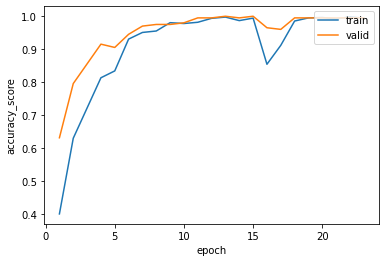

In [14]:
t.validation_curve()

In [ ]:
t.evaluator

    accuracy_score  epoch      loss  phase
0         0.425063    1.0  1.491239  train
1         0.686567    1.0  0.926665  valid
2         0.649244    2.0  0.902697  train
3         0.761194    2.0  0.623837  valid
4         0.755668    3.0  0.687878  train
5         0.900498    3.0  0.461148  valid
6         0.885390    4.0  0.405517  train
7         0.925373    4.0  0.307273  valid
8         0.922544    5.0  0.309272  train
9         0.925373    5.0  0.261097  valid
10        0.909320    6.0  0.313361  train
11        0.950249    6.0  0.208358  valid
12        0.942695    7.0  0.222698  train
13        0.970149    7.0  0.175597  valid
14        0.962846    8.0  0.159804  train
15        0.970149    8.0  0.128235  valid
16        0.971662    9.0  0.124121  train
17        0.970149    9.0  0.107585  valid
18        0.978589   10.0  0.105747  train
19        0.975124   10.0  0.109567  valid

In [ ]:
splitfolders.ratio("content/data", output="output", seed=1337, ratio=(.8, .1, .1), group_prefix=None) 